# <strong>Bitcoin Recurrent Neural Network<strong>
### Justin Marlor & Habit Blunk
##### *Colorado State University*

This is our notebook that automatically copies data from [this dataset hosted on Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data), then throws it into various neural networks and predicts the price of Bitcoin.

To run it:

1. Run the script located in this repository at `./env-script`. This will set up your virtual environment. 
2. Run `source ./venv/bin/activate`. This will put you in the virtual environment we have set up, so this notebook can be run on any machine so long as it has Python 3.x and can install the dependencies at `./dependencies.txt`.
3. Paste this into `~/.config/kaggle/kaggle.json`:
    ```json
    {
      "username": "justinmarlor",
      "key": "b98017f9291bfa83686f6c6780d38e04"
    }
    ```
4. Execute each cell in sequence.

#### Cell 1: Imports and TimeSeries class

In [8]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torch.nn import GRU, RNN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, tensor, seq_length, target_idx):
        self.tensor = tensor
        self.seq_length = seq_length
        self.target_idx = target_idx

    def __len__(self):
        return len(self.tensor) - self.seq_length

    def __getitem__(self, idx):
        seq = self.tensor[idx:idx + self.seq_length]
        target = self.tensor[idx + self.seq_length, self.target_idx]
        return seq, target 

#### Cell 2: Grabbing and preprocessing data

In [4]:
result = subprocess.run(['bash', './add-run-kaggle-bitcoin'], capture_output=True,text=True)

print(result.stdout)
print(result.stderr)

if result.returncode == 0:
    df = pd.read_csv("kaggle-bitcoin/upload/btcusd_1-min_data.csv", dtype={"Volume": float}, low_memory=False)
    df['datetime'] = pd.to_datetime(df['Timestamp'].astype('Int64'), unit='s', errors='coerce')
    display(df)

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: kaggle-bitcoin (0.1.0)
Current time (UTC): 2025-04-28 17:52:16.505831+00:00
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
Checking for missing data...
Last data point in dataset: 2025-04-28 00:46:00+00:00 (Unix: 1745801160)
Current time (minus buffer): 2025-04-28 17:42:50.777898+00:00 (Unix: 1745862170)
Gap of 61010 seconds detected.
Missing data detected.
Fetching data from 2025-04-28 00:46:00+00:00 to 2025-04-28 17:42:50+00:00
Fetching chunk 1/2: 2025-04-28 00:46:00+00:00 to 2025-04-28 17:26:00+00:00
  - Retrieved 1000 data points
Fetching chunk 2/2: 2025-04-28 17:26:00+00:00 to 2025-04-28 17:42:50+00:00
  - Retrieved 1000 data points
Total new data points: 2000
Combined dataset size before deduplication: 7007326
Final dataset size after deduplication: 7006342
Updated dataset saved to upload/btcusd_1-min_data.csv

/home/Jmarlor/CS345/bitcoin

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:05:00
...,...,...,...,...,...,...,...
7006337,1.745862e+09,93800.00,93857.00,93800.00,93857.00,0.007501,2025-04-28 17:38:00
7006338,1.745862e+09,93900.00,93912.00,93897.00,93899.00,0.129609,2025-04-28 17:39:00
7006339,1.745862e+09,93898.00,93898.00,93867.00,93867.00,0.767242,2025-04-28 17:40:00
7006340,1.745862e+09,93868.00,93868.00,93855.00,93855.00,0.539900,2025-04-28 17:41:00


#### PCA

In [31]:
X = df.drop(columns=['Timestamp', 'datetime'])

# Standardizing data
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=X.columns)
print(loadings)

#Shrinking the number of rows to increase training speed
df = df[::10]
print(df)

             PC1       PC2
Open    0.499138  0.029356
High    0.499137  0.029428
Low     0.499139  0.029270
Close   0.499138  0.029349
Volume -0.058702  0.998276
            Timestamp      Open      High       Low     Close     Volume  \
0        1.325412e+09      4.58      4.58      4.58      4.58   0.000000   
10       1.325413e+09      4.58      4.58      4.58      4.58   0.000000   
20       1.325413e+09      4.58      4.58      4.58      4.58   0.000000   
30       1.325414e+09      4.58      4.58      4.58      4.58   0.000000   
40       1.325414e+09      4.58      4.58      4.58      4.58   0.000000   
...               ...       ...       ...       ...       ...        ...   
7006300  1.745860e+09  93748.00  93821.00  93748.00  93821.00   0.879694   
7006310  1.745860e+09  93745.00  93745.00  93710.00  93710.00   1.280916   
7006320  1.745861e+09  93701.00  93701.00  93644.00  93686.00  29.053569   
7006330  1.745861e+09  93573.00  93576.00  93551.00  93566.00   2.072496   
70

This PCA shows us that there is a very similar correlation value between each of the 'open', 'high', 'low', 'close' columns. The trading volume is the other feature that has a strong correlation to the price of bitcoin. We will proceed to train the models using 2 features to remove redundant information.

#### Cell 3: plotting current dataset

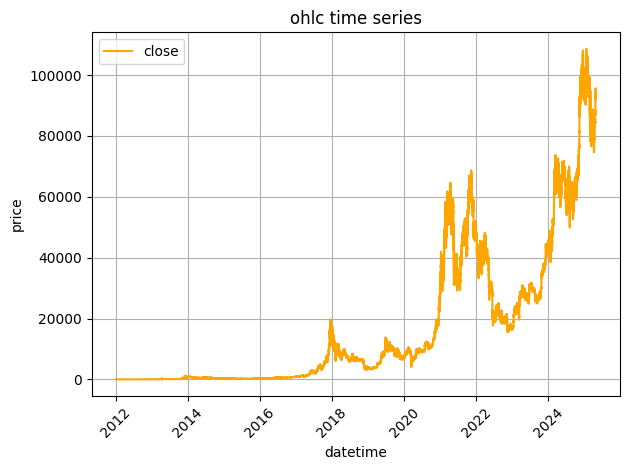

In [32]:
plt.plot(df['datetime'], df['Close'], label='close', color='orange')
plt.xlabel('datetime')
plt.ylabel('price')
plt.title('ohlc time series')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cell 4: Create tensor and define functions

In [33]:
df_tensor = df.drop(columns=['datetime'],).astype('float32').dropna()
scaler = StandardScaler()
normalized_values = scaler.fit_transform(df_tensor.values)
tensor = torch.tensor(df_tensor.values, dtype=torch.float32)
close_idx = df.columns.get_loc('Close')

def create_sequences(tensor, seq_length, target_idx):
  sequences = []
  targets = []

  for i in range(len(tensor) - seq_length):
    seq = tensor[i:i + seq_length]
    target_value =  tensor[i + seq_length, target_idx]
    sequences.append(seq)
    targets.append(target_value) 
  return torch.stack(sequences), torch.tensor(targets).unsqueeze(1)

seq_length = 60
batch_size = 64
dataset = TimeSeriesDataset(tensor, seq_length, close_idx)

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

def train_model(model, train_loader, val_loader, num_epochs=4, lr=1e-3):
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
      pred = model(batch_X)
      loss = loss_fn(pred.squeeze(), batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for val_X, val_y in val_loader:
        val_pred = model(val_X)
        val_loss += loss_fn(val_pred.squeeze(), val_y).item()
    print(f"epoch {epoch + 1}, train loss: {total_loss / len(train_loader):.4f}, val loss: {val_loss / len(val_loader):.4f}")


#### Cell 5: RNN model training class

In [34]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim=1):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out

#### Cell 6: Training RNN Model + storing data into .pth file

In [ ]:
rnn_model = RNNModel(input_dim=tensor.shape[1], hidden_dim=64)
train_model(rnn_model, train_loader, val_loader) 
torch.save(rnn_model.state_dict(), "rnn_model.pth")

#### Cell 7: To load trained RNN data

In [ ]:
rnn_model = RNNModel(input_dim=tensor.shape[1], hidden_dim=64)
rnn_model.load_state_dict(torch.load("rnn_model.pth"))

#### Cell 8: Recursive prediction method

In [ ]:
def predict_future(model, input_seq, steps, target_idx):
    model.eval()
    predictions = []
    seq = input_seq.clone()

    with torch.no_grad():
        for _ in range(steps):
            pred = model(seq.unsqueeze(0))
            pred_value = pred.item()
            predictions.append(pred_value)

            # Create the next sequence by shifting and adding the prediction
            new_step = seq[-1].clone()
            new_step[target_idx] = pred_value  # Only update the target (Close price)
            seq = torch.cat((seq[1:], new_step.unsqueeze(0)), dim=0)

    return predictions

#### Cell 9: How many values we will predict with our trained model.

In [ ]:
last_seq = tensor[-seq_length:]  # Get the last sequence from the dataset
future_steps = 100  # our chosen number of predictions
normalized_predictions = predict_future(rnn_model, last_seq, steps=future_steps, target_idx=close_idx)
print(normalized_predictions)
print(set(normalized_predictions))

#### Cell 10: LSTM model training class

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim=1):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) 
    self.fc = nn.Linear(hidden_dim, 1)

  def forward(self, x): 
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

#### Cell 11: Training LSTM against dataset, then saving it in a `*.pth` file

In [ ]:
lstm_model = LSTMModel(input_dim = tensor.shape[1], hidden_dim=64)
train_model(lstm_model, train_loader, val_loader)
torch.save(lstm_model.state_dict(), "lstm_model.pth")

#### Loading trained LSTM Model data

In [ ]:
lstm_model = LSTMModel(input_dim=tensor.shape[1], hidden_dim=64)
lstm_model.load_state_dict(torch.load("lstm_model.pth"))

In [ ]:
last_seq = tensor[-seq_length:]  # Get the last sequence from the dataset
future_steps = 100  # our chosen number of predictions
normalized_predictions = predict_future(lstm_model, last_seq, steps=future_steps, target_idx=close_idx)
print(normalized_predictions)
print(set(normalized_predictions))